<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/6_Linear_twoclass_classification/6_9_Weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6: Linear two-class classification

# Weighted Two-Class Classification

Because our two-class classification cost functions are *summable over individual points* we can - as we did with regression in [Section 5.5](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_5_Weighted.html) - weight individual points in order to emphasize or de-emphasize their importance to a classification model.  This is called *weighted classification*.  This idea is often implemented when dealing with *highly imbalanced* two class datasets, as we discuss here.

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_6_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_datasets
    else:
        print('chapter_6_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_6_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_library
    else:
        print('chapter_6_library already cloned!')

    # clone videos
    if not Path('chapter_6_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/6_Linear_twoclass_classification/chapter_6_videos
    else:
        print('chapter_6_videos already cloned!')


# append path for local library, data, and image import
import sys
sys.path.append('./chapter_6_library')
sys.path.append('./chapter_6_datasets') 
sys.path.append('./chapter_6_videos') 

# import section helper
import section_6_9_helpers

# dataset paths
data_path_1 = 'chapter_6_datasets/census_data.csv'
data_path_2 = 'chapter_6_datasets/3d_classification_data_v2_mbalanced.csv'

# video paths
video_path_1 = 'chapter_6_videos/animation_2.mp4'

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from base64 import b64encode

def show_video(video_path, width = 1000):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={width} controls><source src="{video_url}"></video>""")

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=6e55dea36c3e68523e63c676e3de7283e372d3964a258837ae7c38f52fa60df3
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Cloning into 'chapter_6_datasets'...
done.
Cloning into 'chapter_6_library'...
done.
Cloning into 'chapter_6_videos'...
done.


## Weighted two-class classification

Just as we saw with regression in [Section 5.5](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_5_Weighted.html), weighted classification cost functions naturally arise due to epeated points in a dataset.  When collecting metadata (e.g., census data) it is not so uncommon collect duplicate entries - multiple people having similar/the same stats based on a given survey.  

Below we take a standard census dataset and plot a subset of it along a single input feature.  With only one feature taken into account we end up with multiple entries of the same datapoint, which we show visually via the radius of each point (the more times a given datapoint appears in the dataset the larger we make the radius).  These datapoints should not be thrown away - they did not arise due to some error in data collecting / storage -  they represent the true dataset.    

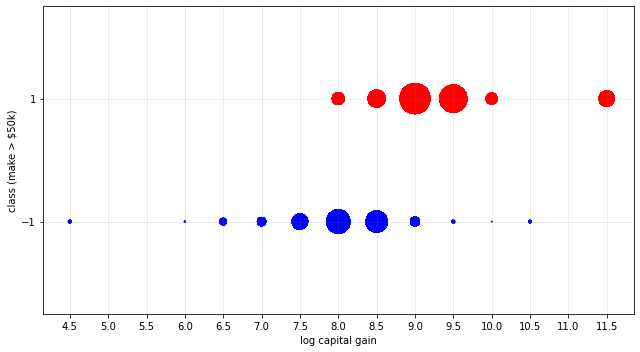

In [2]:
demo1 = section_6_9_helpers.static_visualizer()
demo1.plot(data_path_1)

Just as with a regression cost, if we examine any two-class classification cost it will 'collapse', with summands containing identical points combining naturally.  One can see this by performing the same kind of simple exercise used in [Section 5.5](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_5_Weighted.html) to illustrate this fact for regression.  This leads to the notion of *weighting* two-class cost functions, like e.g., the weighted softmax below (written using our general `model` notation used)

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^P\beta_p\,\text{log}\left(1 + e^{-y_p\text{model}\left(x_p,\mathbf{w}\right)}\right).
\end{equation}

Here the values $\beta_1,\,\beta_2,\,...,\,\beta_P$ are fixed *point-wise* weights.  That is, a unique point $\left(x_p,\,y_p\right)$ in the dataset has weight $\beta_p = 1$ whereas if this point is repeated $R$ times in the dataset then one instance of it will have weight $\beta_p = R$ while the others have weight $\beta_p = 0$.

Since these weights are fixed (i.e., they are *not* parameters that need to be tuned, like $\mathbf{w}$) we can minimize a weighted classification cost precisely as we would any other e.g,. via a local optimization scheme like gradient descent or Newton's method.

In [3]:
# a Python implementation of the weighted two-class softmax cost function
# setup to compute over mini-batches if desired
def softmax(w,x,y,beta,iter):
    # get batch of points
    x_p = x[:,iter]
    y_p = y[:,iter]
    beta_p = beta[:,iter]

    # compute cost over batch        
    cost = np.sum(beta_p*np.log(1 + np.exp(-y_p*model(x_p,w))))
    return cost/float(np.size(y_p))

Just as with regression, we can also think of *assigning* these fixed weight values to points ourselves based on our 'confidence' of the legitimacy of a datapoint.  If we believe that a point is very trustworthy we can set its corresponding weight $\beta_p$ closer to $1$, and the more untrustworthy we find a point the smaller we set $\beta_p$ in the range $0 \leq \beta_p \leq 1$ where $\beta_p = 0$ implies we do not trust the point at all.  In making these weight selections we of course determine *how important each datapoint is* in the training of the model.

## Dealing with imbalanced datasets via weighted classification

Weighted classification - in the manner detailed above - is often used to deal with *imbalanced datasets*.  These are datasets which contain far more examples of one class of data than the other.  With such datasets it is often easy to achieve a high accuracy by *misclassifying points from the smaller class*.  For example, if a two-class dataset consisted of $90\%$ points with label value $-1$ and $10\%$ points with label $+1$, then simply classifying all datapoints to the $-1$ class would provide $90\%$ accuracy.  

This idea of 'sacrificing' members of the smaller class by misclassifying them (instead of members from the majority class) is - depending on the application - not very desirable.  For example

- if the classification determines whether or not someone has a particularly rare but deadly disease that requires further examination one would likely rather misclassify a healthly individual (and give them further testing) then miss someone with the disease


- if the classification determines whether or not a particular financial transaction was *fraudulant*, one would likely rather misclassify a standard transaction (to review further or alert a customer) than miss an actually fraudulunt transaction

One way of ameliorating this issue is to use a weighted classification cost to alter the behavior of the learned classifier so that it weights points in the smaller class more, and points in the larger class less

In order to produce this outcome it is common to assign such weigths *inversely proportional to the number of members of each class*.  That is if we denote $\Omega_{+1}$ and $\Omega{-1}$ index sets for the points in classes $+1$ and $-1$ respectively, then first note that $P = \left\vert \Omega_{+1} \right\vert + \left\vert \Omega_{-1} \right\vert$.  Then denoting $\beta_{+1}$ and $\beta_{-1}$ the weight for each member of class $+1$ and $-1$ respectively we can set these class-wise weights inversely proportional to the number of points in each class as

\begin{array}
\
\beta_{+1} = \frac{1}{\left\vert \Omega_{+1} \right\vert} \\
\beta_{-1} = \frac{1}{\left\vert \Omega_{-1} \right\vert}. \\
\end{array}

Below weight of minority class is increased as you move the animation slider from left to right, with new classification shown as result (and point size of minority red class increased for visualization).  As you increase the weighting on minority class members you incentivise learned classifier to classify these points correctly.

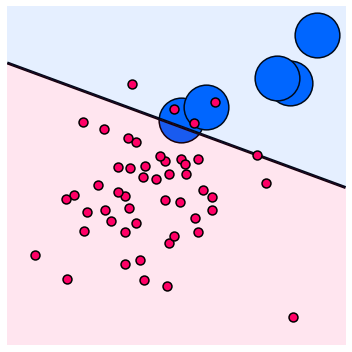

In [4]:
demo4 = section_6_9_helpers.animation_visualizer()
demo4.animate_weightings(video_path_1,data_path_2,num_slides = 50,fps=20)

In [6]:
show_video(video_path_1, width=400)